ResNet-18-attention-transfer
=========

Paying More Attention to Attention: Improving the Performance of Convolutional Neural Networks via Attention Transfer (ICLR 2017):

arxiv: <https://arxiv.org/abs/1512.03385>
    
openreview: <https://openreview.net/forum?id=Sks9_ajex>
    
Training code: <https://github.com/szagoruyko/attention-transfer>

Download model (44.1MB): <https://www.dropbox.com/s/z092wmrgyqn4ys5/resnet-18-at-export.hkl?dl=0>

## Network info

Trained in: [fb.resnet.torch](https://github.com/facebook/fb.resnet.torch/tree/master/pretrained)
    
Test top-1/top5 error: **29.44, 10.12**

In [14]:
import hickle as hkl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from visualize import make_dot

Weights of this networks are in `hdf5` format and should be easy to load in other frameworks

In [13]:
params = hkl.load('resnet-18-at-export.hkl')

# convert numpy arrays to torch Variables
for k,v in params.iteritems():
    print k, v.shape
    params[k] = Variable(torch.from_numpy(v))
    
print '\nTotal parameters:', sum([v.numel() for v in params.itervalues()])

group0.block1.affine0.b (64,)
group0.block1.affine0.a (64,)
group2.block1.conv1 (256, 256, 3, 3)
group0.block1.affine1.b (64,)
group2.block1.conv0 (256, 256, 3, 3)
group0.block1.affine1.a (64,)
group3.block1.conv1 (512, 512, 3, 3)
affine0.a (64,)
affine0.b (64,)
affine_last.b (512,)
affine_last.a (512,)
group1.block1.affine1.a (128,)
group1.block1.affine1.b (128,)
group1.block1.affine0.a (128,)
group1.block1.affine0.b (128,)
group0.block0.conv1 (64, 64, 3, 3)
group0.block0.conv0 (64, 64, 3, 3)
group3.block0.conv_dim (512, 256, 1, 1)
group0.block1.conv0 (64, 64, 3, 3)
group0.block1.conv1 (64, 64, 3, 3)
group3.block0.affine1.b (512,)
group3.block0.affine1.a (512,)
group2.block1.affine0.a (256,)
conv0 (64, 3, 7, 7)
group2.block1.affine1.a (256,)
group2.block1.affine1.b (256,)
group3.block1.conv0 (512, 512, 3, 3)
fc.weight (1000, 512)
group2.block0.conv1 (256, 256, 3, 3)
group2.block0.conv0 (256, 128, 3, 3)
fc.bias (1000,)
group3.block0.affine0.b (256,)
group3.block1.affine0.b (512,)
group

## Model definition

In [10]:
def define_model(params):
    def affine(input, params, base):
        a = params[base+'.a'].view(1,-1,1,1).expand_as(input)
        b = params[base+'.b'].view(1,-1,1,1).expand_as(input)
        return input * a + b

    def group(o, params, base, stride):
        block_id = 0
        G = lambda name: ('%s.block%d.%s') % (base, block_id, name)
        if base == 'group0':
            x = o
            o = F.conv2d(x, params[G('conv0')], padding=1)
            o = F.relu(affine(o, params, G('affine1')))
            o = F.conv2d(o, params[G('conv1')], padding=1)
            o += x
        else:
            x = F.relu(affine(o, params, G('affine0')))
            o = F.conv2d(x, params[G('conv0')], padding=1, stride=stride)
            o = F.relu(affine(o, params, G('affine1')))
            o = F.conv2d(o, params[G('conv1')], padding=1)
            o += F.conv2d(x, params[G('conv_dim')], stride=stride)
        block_id = 1
        x = o
        o = F.relu(affine(x, params, G('affine0')))
        o = F.conv2d(o, params[G('conv0')], padding=1)
        o = F.relu(affine(o, params, G('affine1')))
        o = F.conv2d(o, params[G('conv1')], padding=1)
        o += x
        return o

    def f(input, params):
        o = F.conv2d(input, params['conv0'], stride=2, padding=3)
        o = F.relu(affine(o, params, 'affine0'))
        o = F.max_pool2d(o, 3, 2, 1)
        o_g0 = group(o, params, 'group0', 1)
        o_g1 = group(o_g0, params, 'group1', 2)
        o_g2 = group(o_g1, params, 'group2', 2)
        o_g3 = group(o_g2, params, 'group3', 2)
        o = F.relu(affine(o_g3, params, 'affine_last'))
        o = F.avg_pool2d(o, 7, 1, 0)
        o = o.view(o.size(0), -1)
        o = F.linear(o, params['fc.weight'], params['fc.bias'])
        return o
    return f

f = define_model(params)

In [11]:
y = f(Variable(torch.randn(1,3,224,224)), params)
print y

Variable containing:
-1.0013 -0.1824  1.1955  ...  -0.9812  0.2856 -0.2754
[torch.FloatTensor of size 1x1000]



do simple fprop, output shape should be `1x1000`

## Visualization

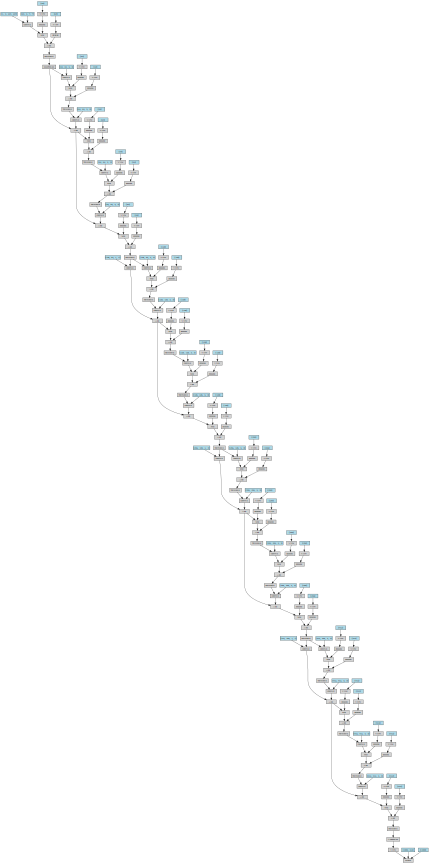

In [12]:
make_dot(y)